## This is an attempt to simulate the classical Coulomb interaction between a proton and an electron in 3D

A typical mechanics simulation needs two things.

- Objects with certain properties (in this case, charged particles with mass)
- A law that utilizes those properties (in this case, the classical Coulomb interaction)

In addition to math and numpy, I have written a custom module called 'physics' inside the modules directory. It contains the definition of the physics objects, the law that governs the interaction between these objects, and how the properties of the object evolve with time.

(This is analogous to how MC generators in HEP works. If you want to modify this example for HEP, you'll have to modify the 'Particle' class to include all the Standard Model parameters for a particle, replace the force law with the SU(3)xSU(2)xU(1) interaction, and the time evolution part with Feynman's Path Integral.)

Now, let's import all the modules that we want, and also define some standard constants.

In [1]:
import math
import numpy as np
import pandas as pd
from modules.physics import *

e = 1.602/(10**19) #Coulomb
mass_p = 1.67/(10**27) #kg
mass_e = 9.11/(10**31) #kg

### Initialising the problem

I have made a class called ```Vector``` which can store a list of numbers. These numbers can be thought of as the components of a vector. This class also has inbuilt functions that can return the magnitude and the direction of the vector. I also made  another class called ```Particle``` which contains all the properties of particcls that we are interested in. It also utilizes some features from the previous class. The following shows how to declare position and velocity vectors, and then how to define a particle using those vectors.

*Tip : Make sure to nudge at least one particle in some direction, so that the plots are not boring.*

**Scenario : In the initial state, there is a proton at rest at (0, 0, 0) and an electron at (1, 1, 1). The electron has an initial velocity of ```10 m/s``` along the z direction.**

In [2]:
#Initial positions of the particles:
pos_ip, vel_ip = Vector([0, 0, 0]), Vector([0, 0, 0])
pos_ie, vel_ie = Vector([1, 1, 1]), Vector([0, 0, 10])

#Examples on how to use the Vector class:
print(f'The components of a vector are : {pos_ie.vector()}')
print(f'The corresponding unit vector is : {pos_ie.direction()}')
print(f'Magnitude of this vector : {pos_ie.magnitude()}')
print(f'Same vector multiplied by 3 : {pos_ie.scale(3)}')

def Initialise():
    part1 = Particle(mass_p, e, pos_ip, vel_ip)
    part2 = Particle(mass_e, -e, pos_ie, vel_ie)
    return part1, part2

The components of a vector are : [1, 1, 1]
The corresponding unit vector is : [0.5773502691896258, 0.5773502691896258, 0.5773502691896258]
Magnitude of this vector : 1.7320508075688772
Same vector multiplied by 3 : [3, 3, 3]


**Note : I decided to execute this initialisation step as a function, so that you can call the funtion right before the time count starts. This is to avoid the problem where the system evolves from whereever jupyter-notebook saved it last time, instead of evolving from the actual initial state the user defined.**

##### The following step is just a check on whether things are working so far or not. 
For a small step of time ```dt```, we can print out some basic results as follows.

In [3]:
proton, electron = Initialise()
force_ep = force(electron, proton)

print(f'Initial force on the electron by the proton is {force_ep.magnitude()} (Newtons)')
print(f'This force is along {force_ep.direction()}')

#Given this force on the electron, the nudge on the electron for an interval of dt is given below.
dt = 0.001
acc, newvel, shift = nudge(electron, force_ep, dt)

print(f'\nDue to this force, the following changes happen after {dt} seconds')
print(f'Acceleration = {acc}')
print(f'New velocity = {newvel}')
print(f'Shift in space = {shift}')

Initial force on the electron by the proton is 7.699212000000001e-29 (Newtons)
This force is along [-0.5773502691896257, -0.5773502691896257, -0.5773502691896257]

Due to this force, the following changes happen after 0.001 seconds
Acceleration = [-48.79409572720085, -48.79409572720085, -48.79409572720085]
New velocity = [-0.04879409572720085, -0.04879409572720085, 9.951205904272799]
Shift in space = [0.9999756029521364, 0.9999756029521364, 1.0099756029521365]


### Evolving the system with time

The setup is ready. Now we want to see how this system evolves with time. For that, we need to define a time period, and a step of ```dt```. Ideally, this step-time has to be small, because I am not considering the continuous chnage of the interaction while we are calculating the change from ```t``` to ```t+dt```.

In [4]:
proton, electron = Initialise()

dt = 0.001 #second
duration = 1 #second
time = np.arange(0, duration+dt, dt)

#I want to store information in the following lists, and later convert them to pandas dataframes
ex, ey, ez = [], [], []      #coordinates of the electron
evx, evy, evz = [], [], []   #velocity components 
px, py, pz = [], [], []      #coordinates of the proton
pvx, pvy, pvz = [], [], []   #velocity components

for t in time:   
    # Nudge on the electron:
    force_ep = force(electron, proton)
    acc, vel, pos = nudge(electron, force_ep, dt)
    electron.pos = Vector(pos)
    electron.vel = Vector(vel)
    
    ex.append(electron.pos.vector()[0])
    ey.append(electron.pos.vector()[1])
    ez.append(electron.pos.vector()[2])
    evx.append(electron.vel.vector()[0])
    evy.append(electron.vel.vector()[1])
    evz.append(electron.vel.vector()[2])
    
    # Nudge on the proton:
    force_pe = force(proton, electron)
    acc, vel, pos = nudge(proton, force_pe, dt)
    proton.pos = Vector(pos)
    proton.vel = Vector(vel)
    
    px.append(proton.pos.vector()[0])
    py.append(proton.pos.vector()[1])
    pz.append(proton.pos.vector()[2])
    pvx.append(proton.vel.vector()[0])
    pvy.append(proton.vel.vector()[1])
    pvz.append(proton.vel.vector()[2])

I like to store all the information in pandas dataframes for plotting etc.

In [5]:
column_dict = {0:'x', 1:'y', 2:'z', 3:'vx', 4:'vy', 5:'vz'}

def make_dataframe(list_of_var, dictionary):
    df = pd.DataFrame(list_of_var)
    df = df.transpose()
    df = df.rename(columns = dictionary)
    return df

df_ele = make_dataframe([ex, ey, ez, evx, evy, evz], column_dict)
df_pro = make_dataframe([px, py, pz, pvx, pvy, pvz], column_dict)

print(df_ele.head(5))

          x         y         z        vx        vy        vz
0  0.999976  0.999976  1.009976 -0.048794 -0.048794  9.951206
1  0.999903  0.999903  1.019902 -0.097104 -0.097104  9.902413
2  0.999782  0.999782  1.029780 -0.144938 -0.144938  9.853622
3  0.999613  0.999613  1.039610 -0.192304 -0.192304  9.804835
4  0.999397  0.999397  1.049390 -0.239208 -0.239208  9.756054


### Plotting the trajectories

In the plots, one point corresponds to one instant of time. Therefore, you can estimate the speed of the object by looking at the distance between two consecutive points. Faster objects have their points more spread out compared to the slower objects. In this case, we can see that the proton is so heavy, it barely moves at all.

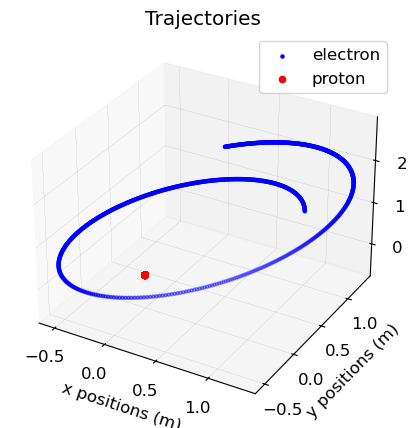


The same image in three different planes:



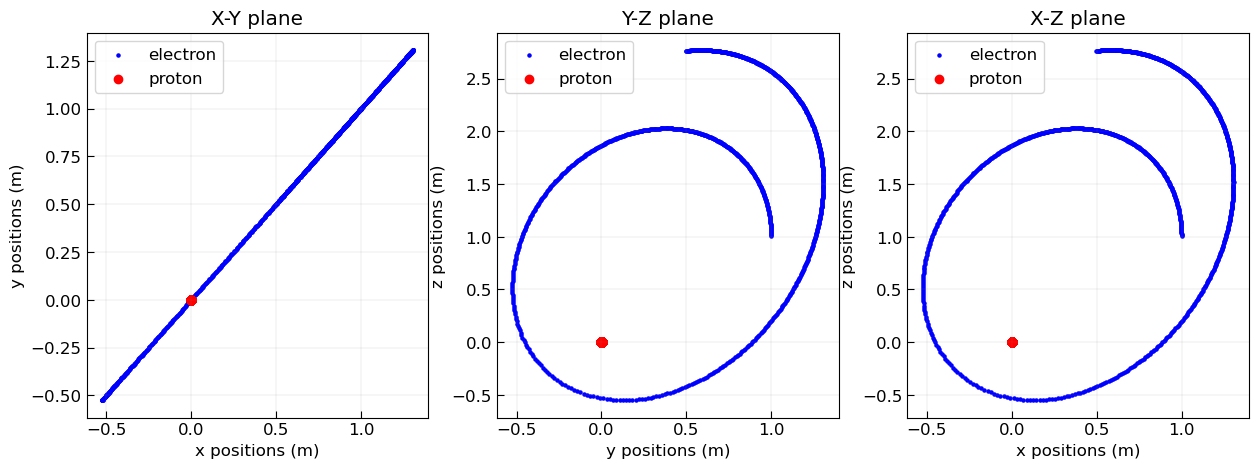

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# --  Axis -- #
mpl.rcParams["xtick.major.size"]  = 5
mpl.rcParams["xtick.minor.size"]  = 5
mpl.rcParams["ytick.major.size"]  = 5
mpl.rcParams["ytick.minor.size"]  = 5
mpl.rcParams["xtick.direction"]  = "in"
mpl.rcParams["ytick.direction"]  = "in"
mpl.rcParams['axes.grid'] = True
#mpl.rcParams['axes.grid.axis'] = 'y'
mpl.rcParams['grid.color'] = 'grey'
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams["axes.labelsize"]= 12

# -- Font -- #
mpl.rcParams['font.size']= 12
#mpl.rcParams['font.family']='serif'

fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')
ax.scatter3D(df_ele['x'], df_ele['y'], df_ele['z'], s=5, color='blue', label='electron')
ax.scatter3D(df_pro['x'], df_pro['y'], df_pro['z'], color='red', label='proton')
ax.set_xlabel('x positions (m)')
ax.set_ylabel('y positions (m)')
ax.set_zlabel('z positions (m)')
ax.set_title('Trajectories')
ax.legend(loc=0)

#Setting the viewing angle to a top-down view
#ax.view_init(elev=90, azim=0)
plt.show()

print("\nThe same image in three different planes:\n")

fig, ax1 = plt.subplots(1, 3, figsize=(15, 5))

ax1[0].scatter(df_ele['x'], df_ele['y'], s=5, color='blue', label='electron')
ax1[0].scatter(df_pro['x'], df_pro['y'], color='red', label='proton')
ax1[0].set_xlabel('x positions (m)')
ax1[0].set_ylabel('y positions (m)')
ax1[0].set_title('X-Y plane')
ax1[0].legend(loc=0)

ax1[1].scatter(df_ele['y'], df_ele['z'], s=5, color='blue', label='electron')
ax1[1].scatter(df_pro['y'], df_pro['z'], color='red', label='proton')
ax1[1].set_xlabel('y positions (m)')
ax1[1].set_ylabel('z positions (m)')
ax1[1].set_title('Y-Z plane')
ax1[1].legend(loc=0)

ax1[2].scatter(df_ele['x'], df_ele['z'], s=5, color='blue', label='electron')
ax1[2].scatter(df_pro['x'], df_pro['z'], color='red', label='proton')
ax1[2].set_xlabel('x positions (m)')
ax1[2].set_ylabel('z positions (m)')
ax1[2].set_title('X-Z plane')
ax1[2].legend(loc=0)

plt.show()